# Recurrent Neural Nets for Sentiment Analysis

Recurrent neural nets (RNNs) are models specialized in sequence learning, that is, problems where the input data is enumerated collection of values (escalars, vectors or multi-dimensional arrays). This type of data is very common in practice, e.g., videos are sequences of image, texts are sequences of words, time series are sequences indexed by time, etc. 

In this notebook, we'll build simple RNNs for sentiment analysis posing the problem as a sequence classification problem.


<table align='left'>
<tr>
<td><img src='https://miro.medium.com/max/2658/0*sm-7smnbyLioThPQ.png' width='650'/></td>
</tr>
</table>



# Ethics & Teamwork

The following is an original work of discussion, analysis and conclusion as part of the Machine Learning for Classification course in the Master in Data Science & Business Analytics at Bologna Business School. 

# Software and Tools

As in previous examples, we will use the basic ecosystem for data science in python (numpy, sklearn, pandas, etc) as well as Keras, a very complete and intuitive proxy to TensorFlow (a more powerful but more technical library for deep learning).


<table align='left'>
<tr>
<td><img src='https://keras.io/img/logo.png' width='450'/></td>
<td><img src='https://www.theta.co.nz/media/3177/tensorflow.png' width='450'/></td>
</tr>
</table>



# Data

We will use data from a small corpus called *Twitter US Airline Sentiment* available on Kaggle. You can download the data using the code or the Google drive link below.




In [ ]:
!wget Tweets-Airline.csv www.inf.utfsm.cl/~jnancu/Tweets-Airline.csv

--2021-04-01 17:14:46--  http://tweets-airline.csv/
Resolving tweets-airline.csv (tweets-airline.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘tweets-airline.csv’
URL transformed to HTTPS due to an HSTS policy
--2021-04-01 17:14:46--  https://www.inf.utfsm.cl/~jnancu/Tweets-Airline.csv
Resolving www.inf.utfsm.cl (www.inf.utfsm.cl)... 200.1.19.11, 2800:270:c::11
Connecting to www.inf.utfsm.cl (www.inf.utfsm.cl)|200.1.19.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [application/octet-stream]
Saving to: ‘Tweets-Airline.csv.1’

Tweets-Airline.csv. 100%[===================>]   3.26M  1.92MB/s    in 1.7s    

2021-04-01 17:14:50 (1.92 MB/s) - ‘Tweets-Airline.csv.1’ saved [3421431/3421431]

FINISHED --2021-04-01 17:14:50--
Total wall clock time: 3.8s
Downloaded: 1 files, 3.3M in 1.7s (1.92 MB/s)


https://drive.google.com/file/d/1C28kpMfBK3cc81SBUU7h2fLYyEPBgIFZ/view?usp=sharing

There are 14.640 tweets posted by users of a well-known airline. The tweets have been manually classified as: positives, negatives o neutrals. The task is to design a model to predict the sentiment corresponding to novel tweets.


In [ ]:
path  = ''
file  = 'Tweets-Airline.csv'

import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

data= pd.read_csv(path+file, sep=',')
print(data.shape)

data.head(5)

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


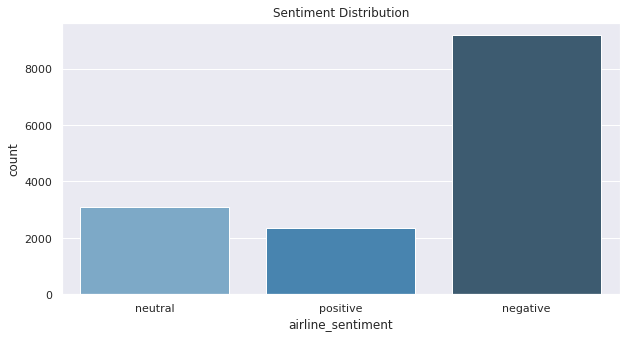

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

print("\n")
fig, ax = plt.subplots(figsize=(10,5),nrows=1)
sns.countplot(data['airline_sentiment'],palette="Blues_d")
ax.set_title('Sentiment Distribution')
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


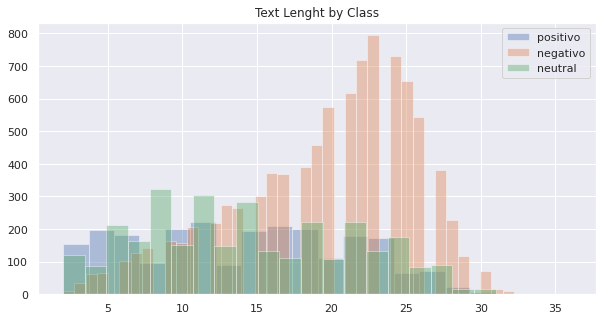

In [ ]:
lenghts_pos = []
lenghts_neg = []
lenghts_neutral = []

for sentence,label in zip(data['text'],data['airline_sentiment']):
  if label == 'negative':
    lenghts_neg.append(len(sentence.lower().split()))
  if label == 'positive':
    lenghts_pos.append(len(sentence.lower().split()))
  if label == 'neutral':
    lenghts_neutral.append(len(sentence.lower().split()))

print("\n")
fig, ax = plt.subplots(figsize=(10,5),nrows=1)
sns.distplot(lenghts_pos,hist=True, kde=False, norm_hist=False, label='positivo',ax=ax)
sns.distplot(lenghts_neg,hist=True, kde=False, norm_hist=False, label='negativo',ax=ax)
sns.distplot(lenghts_neutral,hist=True, kde=False, norm_hist=False, label='neutral',ax=ax)
ax.set_title('Text Lenght by Class')
ax.legend()
plt.show()


# Splits & Class Selection

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


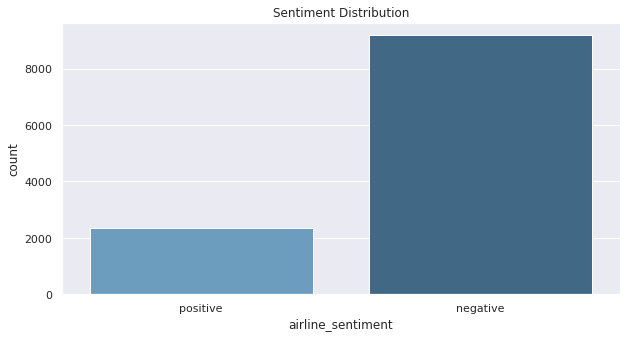

In [ ]:
lab_tweets = data[['text','airline_sentiment']]
lab_tweets = lab_tweets[lab_tweets['airline_sentiment'] != 'neutral']
np.random.seed(30)
msk = np.random.rand(len(lab_tweets)) < 0.8
data = lab_tweets
data_for_trans = lab_tweets

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

print("\n")
fig, ax = plt.subplots(figsize=(10,5),nrows=1)
sns.countplot(data['airline_sentiment'],palette="Blues_d")
ax.set_title('Sentiment Distribution')
plt.show()

# From Tweets to Vectors

## Stopwords Filtering & More

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

sentences = []
labels = []

for sentence,label in zip(data['text'],data['airline_sentiment']):
  labels.append(label)
  for word in stopwords.words('english'):
    token = ''+ word + ''
    sentence = sentence.replace(token,'')
    sentence = sentence.replace(' ', ' ')
  sentences.append(sentence)

print(len(sentences))
print(sentences[0])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
11541
@VrgnArc plu ' e crcl   expence... ck.


## Vectorization

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

TF_tokenizer = Tokenizer(num_words=5000)
TF_tokenizer.fit_on_texts(sentences)
tweet_vectors = TF_tokenizer.texts_to_matrix(sentences, mode='freq')#binary', 'count', 'tfidf'
print(tweet_vectors.shape)


(11541, 5000)


# From Tweets to Sequences

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tweets = data['text'].values

Seq_tokenizer = Tokenizer(num_words=5000)
Seq_tokenizer.fit_on_texts(tweets)

vocab_size = len(Seq_tokenizer.word_index) + 1
sequences = Seq_tokenizer.texts_to_sequences(tweets)
padded_sequences = pad_sequences(sequences, maxlen=200)

print(tweets[0])
print(sequences[0])
print(padded_sequences[0])


@VirginAmerica plus you've added commercials to the experience... tacky.
[103, 575, 530, 1287, 2416, 1, 2, 177]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 

# Feed-Forward Net on Term-frequency (TF) Vectors

## Model

In [ ]:

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam
from keras.layers import Dropout


def classic_model(num_words=5000):

  model = Sequential()
  model.add(Dense(50, input_shape=(num_words,), activation="relu"))
  model.add(Dense(20,activation="relu"))
  model.add(Dense(1,activation="sigmoid"))

  opt = SGD(0.1)
  model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

  return model


In [ ]:
model_FF = classic_model(num_words=5000)
model_FF.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                250050    
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 251,091
Trainable params: 251,091
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
tweet_train = tweet_vectors[msk]
tweet_test = tweet_vectors[~msk]

sentiments = data['airline_sentiment'].factorize()
sentiments_labels = sentiments[0]
sentiments_tags = sentiments[1]
print(sentiments_labels)

res_l, res_c = np.unique(sentiments_labels, return_counts=True)
print(res_l,res_c)
sentiment_train = sentiments_labels[msk]
sentiment_test = sentiments_labels[~msk] 

[0 1 1 ... 0 1 1]
[0 1] [2363 9178]


In [ ]:
model_FF = classic_model(num_words=5000)
history_FF = model_FF.fit(tweet_train, sentiment_train, batch_size=64, epochs=20, verbose=2, validation_data=(tweet_test, sentiment_test))


[0 1 1 ... 0 1 1]
[0 1] [2363 9178]
Epoch 1/20
144/144 - 3s - loss: 0.5147 - accuracy: 0.7965 - val_loss: 0.5133 - val_accuracy: 0.7872
Epoch 2/20
144/144 - 1s - loss: 0.4983 - accuracy: 0.7973 - val_loss: 0.5085 - val_accuracy: 0.7872
Epoch 3/20
144/144 - 0s - loss: 0.4919 - accuracy: 0.7973 - val_loss: 0.4988 - val_accuracy: 0.7872
Epoch 4/20
144/144 - 1s - loss: 0.4813 - accuracy: 0.7973 - val_loss: 0.4846 - val_accuracy: 0.7872
Epoch 5/20
144/144 - 0s - loss: 0.4650 - accuracy: 0.7973 - val_loss: 0.4634 - val_accuracy: 0.7872
Epoch 6/20
144/144 - 1s - loss: 0.4425 - accuracy: 0.8100 - val_loss: 0.4350 - val_accuracy: 0.8153
Epoch 7/20
144/144 - 1s - loss: 0.4152 - accuracy: 0.8248 - val_loss: 0.4221 - val_accuracy: 0.8443
Epoch 8/20
144/144 - 0s - loss: 0.3877 - accuracy: 0.8388 - val_loss: 0.3761 - val_accuracy: 0.8464
Epoch 9/20
144/144 - 1s - loss: 0.3715 - accuracy: 0.8472 - val_loss: 0.3547 - val_accuracy: 0.8489
Epoch 10/20
144/144 - 0s - loss: 0.3699 - accuracy: 0.8494 - val

## Evaluation


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


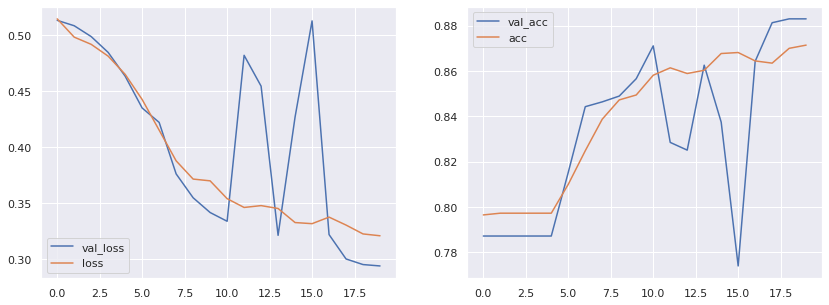


FINAL TEST ACCURACY:  0.8829787234042553

Confusion Matrix



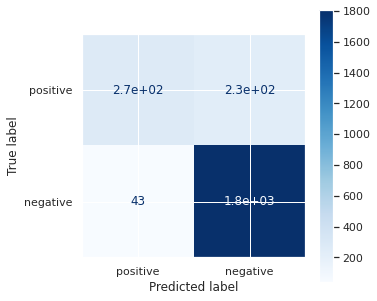


Classification Report

              precision    recall  f1-score   support

    positive       0.86      0.54      0.66       500
    negative       0.89      0.98      0.93      1850

    accuracy                           0.88      2350
   macro avg       0.87      0.76      0.80      2350
weighted avg       0.88      0.88      0.87      2350



In [ ]:


fig, axis = plt.subplots(1, 2, figsize=(14,5))
axis[0].plot(history_FF.history['val_loss'], label='val_loss')
axis[0].plot(history_FF.history['loss'], label='loss')
axis[0].legend()
axis[1].plot(history_FF.history['val_accuracy'], label='val_acc')
axis[1].plot(history_FF.history['accuracy'], label='acc')
axis[1].legend()
plt.show()

y_pred = model_FF.predict(tweet_test).round().astype(int)[:,0]

acc_test = np.mean(sentiment_test == y_pred)

print("\nFINAL TEST ACCURACY: " , acc_test )

target_names = [str(i) for i in range(10)]

print("\nConfusion Matrix\n")
fig, ax = plt.subplots(figsize=(5, 5))
cm = confusion_matrix(sentiment_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sentiments_tags)
disp = disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

print("\nClassification Report\n")

print(classification_report(sentiment_test, y_pred, target_names=sentiments_tags))


In [ ]:
test_tweet ="I always like flying with you"
tweet_vector = TF_tokenizer.texts_to_matrix([test_tweet], mode='freq')
prediction = int(model_FF.predict(tweet_vector).round())
print("TEST TWEET: ",test_tweet)
print("PREDICTION: ",sentiments_tags[prediction])

TEST TWEET:  I always like flying with you
PREDICTION:  negative


Here we can observe how, being memory-less, the FF dense architecture is not able to connect words in the initial positions with words later on in the sentence. This contributes to many instances where negative is predicted but positive is the true class like the test above. 

Will therefore introduce LSTMs in order to improve prediction ability by the model.

# LSTM with Trainable Embedding 

## Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D, SimpleRNN
from tensorflow.keras.layers import Embedding


def recurrent_simple():
  embedding_vector_length = 32
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
  model.add(SpatialDropout1D(0.25))
  model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  return model

def recurrent_double():
  embedding_vector_length = 32
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
  model.add(SpatialDropout1D(0.25))
  model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
  model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  return model

def recurrent_bidirectional():
  embedding_vector_length = 32
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
  model.add(SpatialDropout1D(0.25))
  model.add(Bidirectional(LSTM(50, dropout=0.5, recurrent_dropout=0.5)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  return model


## Training

In [ ]:
seqs_train = padded_sequences[msk]
seqs_test = padded_sequences[~msk]

sentiments = data['airline_sentiment'].factorize()
sentiments_labels = sentiments[0]
sentiments_tags = sentiments[1]
print(sentiments_labels)

res_l, res_c = np.unique(sentiments_labels, return_counts=True)
print(res_l,res_c)
sentiment_train = sentiments_labels[msk]
sentiment_test = sentiments_labels[~msk] 

weights = {0 : 1., 1: 10.}

model_LSTM = recurrent_simple()
history_LSTM = model_LSTM.fit(seqs_train, sentiment_train, epochs=10, batch_size=32, validation_data=(seqs_test, sentiment_test), class_weight = weights)

[0 1 1 ... 0 1 1]
[0 1] [2363 9178]
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 32)           423488    
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 440,139
Trainable params: 440,139
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
288/288 [==============================] - 284s 975ms/step - l

Unfortunately, since LSTMs are very computationally expensive, a warning from Keras lets us know that it will use Gated Recurrent Units (GRUs) instead when running on GPU. 

## Evaluation

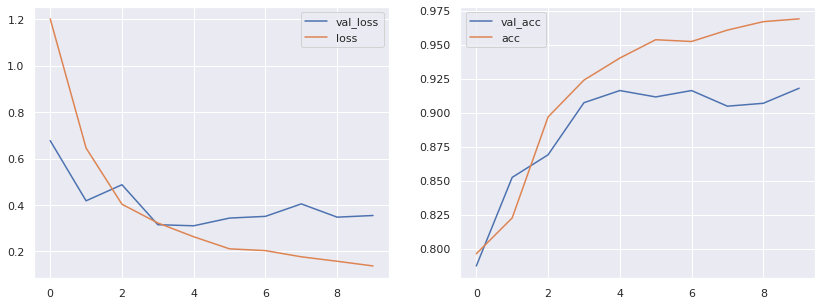


FINAL TEST ACCURACY:  0.9178723404255319

Confusion Matrix



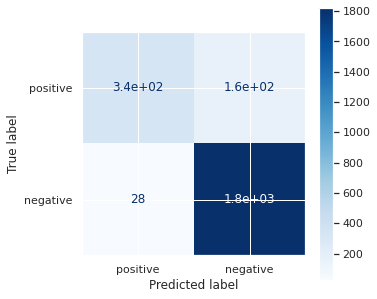


Classification Report

              precision    recall  f1-score   support

    positive       0.92      0.67      0.78       500
    negative       0.92      0.98      0.95      1850

    accuracy                           0.92      2350
   macro avg       0.92      0.83      0.86      2350
weighted avg       0.92      0.92      0.91      2350



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, axis = plt.subplots(1, 2, figsize=(14,5))
axis[0].plot(history_LSTM.history['val_loss'], label='val_loss')
axis[0].plot(history_LSTM.history['loss'], label='loss')
axis[0].legend()
axis[1].plot(history_LSTM.history['val_accuracy'], label='val_acc')
axis[1].plot(history_LSTM.history['accuracy'], label='acc')
axis[1].legend()
plt.show()


y_pred =  model_LSTM.predict(seqs_test).round().astype(int)[:,0]

acc_test = np.mean(sentiment_test == y_pred)

print("\nFINAL TEST ACCURACY: " , acc_test )

target_names = [str(i) for i in range(10)]

print("\nConfusion Matrix\n")
fig, ax = plt.subplots(figsize=(5, 5))
cm = confusion_matrix(sentiment_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sentiments_tags)
disp = disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

print("\nClassification Report\n")

print(classification_report(sentiment_test, y_pred, target_names=sentiments_tags))


In [ ]:
test_tweet ="I always like flying with you"
seq = Seq_tokenizer.texts_to_sequences([test_tweet])
seq = pad_sequences(seq,maxlen=200)
prediction = int(model_LSTM.predict(seq).round().item())
print("TEST TWEET: ",test_tweet)
print("PREDICTION: ",sentiments_tags[prediction])

NameError: ignored

## Simple FF vs simple RNN 

On the surface we might be tempted to look at only the modest increase in accuracy from ~89% to ~92. However, there are two very interesting differences:

1. The model has now significantly less *false negatives*. This can be attributed to the long-short memory that the neurons have, which can allow them to keep what is worthwhile in time and forget what is unnecessary for prediction. 

2. If we perform the test again we can see how the same phrase: "I always like flying with you" now gets classified correctly. Since we excluded the data with neutral labels, neutral tests get classified as negative. 

In [ ]:
test_tweet ="I do not mind flying with you" # NEUTRAL 
seq = Seq_tokenizer.texts_to_sequences([test_tweet])
seq = pad_sequences(seq,maxlen=200)
prediction = int(model_LSTM.predict(seq).round().item())
print("TEST TWEET: ",test_tweet)
print("PREDICTION: ",sentiments_tags[prediction])

NameError: ignored

Additionally, we are achieving high accuracies with just a simple RNN. Let's see if adding another LSTM layer improves the performance. 

## Double Recurrent Model

In [ ]:
model_LSTM = recurrent_double()
history_LSTM = model_LSTM.fit(seqs_train, sentiment_train, epochs=10, batch_size=32, validation_data=(seqs_test, sentiment_test), class_weight = weights)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 32)           423488    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200, 50)           16600     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 460,339
Trainable params: 460,339
Non-trainable params: 0
________________________________________________

## Visualization



The code below creates files with the embedding corresponding to each word. These files are in the format required to visualize them in:  https://projector.tensorflow.org.


In [ ]:
import io

word_index = Seq_tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

embedding_layer = model_LSTM.layers[0] 
weights = embedding_layer.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim) 

out_v = io.open('vecs_learned.tsv', 'w', encoding='utf-8')
out_m = io.open('meta_learned.tsv', 'w', encoding='utf-8')

for word_num in range(1, 5000):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


(13234, 32)


In [ ]:
print("Mounting your Google Drive ...")

from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive',force_remount=True)
 

!cp vecs_learned.tsv "/content/drive/BBS/"
!cp meta_learned.tsv "/content/drive/BBS/"

# Pre-trained Embeddings

## Download

The embeddings can be downloaded using the link below:

In [ ]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

--2021-04-01 11:44:52--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2021-04-01 11:44:52--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2021-04-01 11:44:53--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('glove.twitter.27B.zip', 'r')
zip_ref.extractall('glove-global-vectors-for-word-representation/')
zip_ref.close()

In [ ]:
!ls glove-global-vectors-for-word-representation/

glove.twitter.27B.100d.txt  glove.twitter.27B.25d.txt
glove.twitter.27B.200d.txt  glove.twitter.27B.50d.txt


In [ ]:
emd_dim = 200

emb_dict = {}

glove_file = 'glove.twitter.27B.' + str(emd_dim) + 'd.txt'
glove_dir = 'glove-global-vectors-for-word-representation/'

glove = open(glove_dir+glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

## Using the Embeddings to Set the Net's Weights 

In [ ]:
n_max_words = 5000

emb_matrix = np.zeros((n_max_words, emd_dim))

for w, i in Seq_tokenizer.word_index.items():
    if i < n_max_words:
        vect = emb_dict.get(w)
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break


## Model Definition

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.layers import GRU

def simple_glove():

  glove_model = Sequential()
  glove_model.add(Embedding(n_max_words, emd_dim, input_length=200))
  glove_model.add(Flatten())
  glove_model.add(Dense(1, activation='sigmoid'))
  glove_model.summary()

  glove_model.layers[0].set_weights([emb_matrix])
  glove_model.layers[0].trainable = False

  glove_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return glove_model

def recurrent_glove():

  glove_model = Sequential()
  glove_model.add(Embedding(n_max_words, emd_dim, input_length=200))
  glove_model.add(SpatialDropout1D(0.25))
  glove_model.add(GRU(50, dropout=0.5, recurrent_dropout=0.5))
  glove_model.add(Dropout(0.2))
  glove_model.add(Dense(1, activation='sigmoid'))
  glove_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
  print(glove_model.summary())

  glove_model.layers[0].set_weights([emb_matrix])
  glove_model.layers[0].trainable = False

  glove_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return glove_model


## Training

### Classic Model

In [ ]:
glove_model = simple_glove()
glove_history = glove_model.fit(seqs_train, sentiment_train, epochs=10, batch_size=64, validation_data=(seqs_test, sentiment_test))


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 40001     
Total params: 1,040,001
Trainable params: 1,040,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
144/144 [==============================] - 1s 6ms/step - loss: 0.4239 - accuracy: 0.8092 - val_loss: 0.2929 - val_accuracy: 0.8889
Epoch 2/10
144/144 [==============================] - 1s 5ms/step - loss: 0.2597 - accuracy: 0.9014 - val_loss: 0.2570 - val_accuracy: 0.9034
Epoch 3/10
144/144 [==============================] - 1s 5ms/step - loss: 0.2125 - accurac

### Recurrent Model

In [ ]:
recurrent_glove_model = recurrent_glove()
recurrent_glove_history = recurrent_glove_model.fit(seqs_train, sentiment_train, epochs=10, batch_size=64, validation_data=(seqs_test, sentiment_test))


NameError: ignored

## Evaluation

### Classic Model

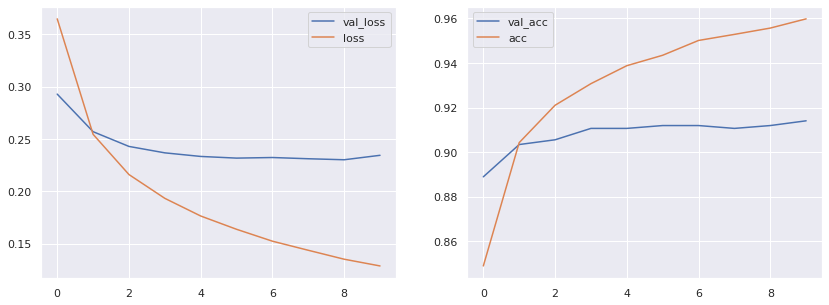


FINAL TEST ACCURACY:  0.9140425531914894

Confusion Matrix



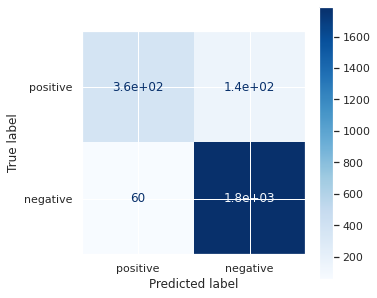


Classification Report

              precision    recall  f1-score   support

    positive       0.86      0.72      0.78       500
    negative       0.93      0.97      0.95      1850

    accuracy                           0.91      2350
   macro avg       0.89      0.84      0.86      2350
weighted avg       0.91      0.91      0.91      2350



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, axis = plt.subplots(1, 2, figsize=(14,5))
axis[0].plot(glove_history.history['val_loss'], label='val_loss')
axis[0].plot(glove_history.history['loss'], label='loss')
axis[0].legend()
axis[1].plot(glove_history.history['val_accuracy'], label='val_acc')
axis[1].plot(glove_history.history['accuracy'], label='acc')
axis[1].legend()
plt.show()


y_pred =  glove_model.predict(seqs_test).round().astype(int)[:,0]

acc_test = np.mean(sentiment_test == y_pred)

print("\nFINAL TEST ACCURACY: " , acc_test )

target_names = [str(i) for i in range(10)]

print("\nConfusion Matrix\n")
fig, ax = plt.subplots(figsize=(5, 5))
cm = confusion_matrix(sentiment_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sentiments_tags)
disp = disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

print("\nClassification Report\n")

print(classification_report(sentiment_test, y_pred, target_names=sentiments_tags))


In [ ]:
test_tweet ="This is so so sad"
seq = Seq_tokenizer.texts_to_sequences([test_tweet])
seq = pad_sequences(seq,maxlen=200)
prediction = int(glove_model.predict(seq).round().item())
print("TEST TWEET: ",test_tweet)
print("PREDICTION: ",sentiments_tags[prediction])


TEST TWEET:  This is so so sad
PREDICTION:  negative


### Recurrent Model

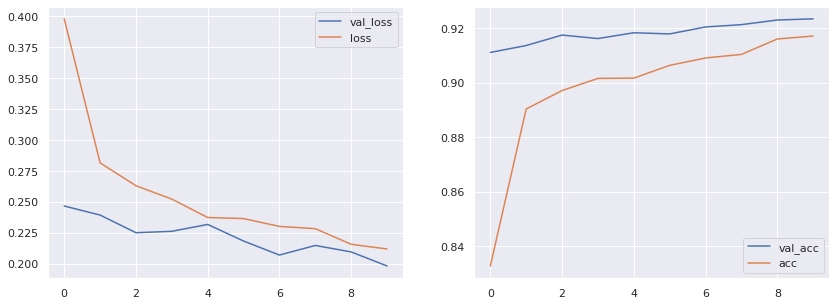


FINAL TEST ACCURACY:  0.9234042553191489

Confusion Matrix



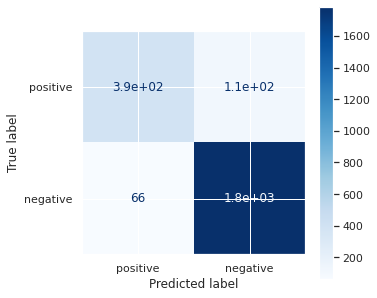


Classification Report

              precision    recall  f1-score   support

    positive       0.85      0.77      0.81       500
    negative       0.94      0.96      0.95      1850

    accuracy                           0.92      2350
   macro avg       0.90      0.87      0.88      2350
weighted avg       0.92      0.92      0.92      2350



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, axis = plt.subplots(1, 2, figsize=(14,5))
axis[0].plot(recurrent_glove_history.history['val_loss'], label='val_loss')
axis[0].plot(recurrent_glove_history.history['loss'], label='loss')
axis[0].legend()
axis[1].plot(recurrent_glove_history.history['val_accuracy'], label='val_acc')
axis[1].plot(recurrent_glove_history.history['accuracy'], label='acc')
axis[1].legend()
plt.show()


y_pred =  recurrent_glove_model.predict(seqs_test).round().astype(int)[:,0]

acc_test = np.mean(sentiment_test == y_pred)

print("\nFINAL TEST ACCURACY: " , acc_test )

target_names = [str(i) for i in range(10)]

print("\nConfusion Matrix\n")
fig, ax = plt.subplots(figsize=(5, 5))
cm = confusion_matrix(sentiment_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sentiments_tags)
disp = disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

print("\nClassification Report\n")

print(classification_report(sentiment_test, y_pred, target_names=sentiments_tags))


In [ ]:
test_tweet ="I thought it might be bad but it ended up being good"
seq = Seq_tokenizer.texts_to_sequences([test_tweet])
seq = pad_sequences(seq,maxlen=200)
prediction = int(recurrent_glove_model.predict(seq).round().item())
print("TEST TWEET: ",test_tweet)
print("PREDICTION: ",sentiments_tags[prediction])


TEST TWEET:  I thought it might be bad but it ended up being good
PREDICTION:  negative


Complex phrases where the presence of positive and negative words but with overall positive sentiment can still be misclassified as negative. One good way to approach this would be the use of bidirectional layers in order to aid the model in learning also in a backwards manner. 

# Bidirectional model without pre-trained embeddings

## Model definition

In [ ]:
def recurrent_bidirectional():
  embedding_vector_length = 32
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
  model.add(SpatialDropout1D(0.25))
  model.add(Bidirectional(LSTM(50, dropout=0.5, recurrent_dropout=0.5)))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  return model


## Training

In [ ]:
model_bd = recurrent_bidirectional()
history_bd = model_bd.fit(seqs_train, sentiment_train, epochs=10, batch_size=64, validation_data=(seqs_test, sentiment_test))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 200, 32)           423488    
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 200, 32)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 100)               33200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 456,789
Trainable params: 456,789
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
144/144 [==============================] - 285s 2s/step - loss: 0.5199 - accuracy: 0.7881 - val_l

## Evaluation

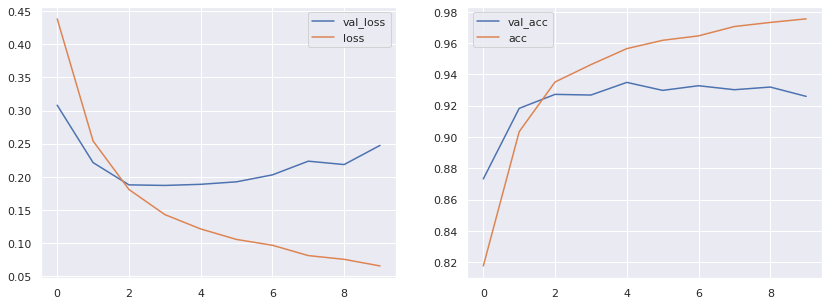


FINAL TEST ACCURACY:  0.9259574468085107

Confusion Matrix



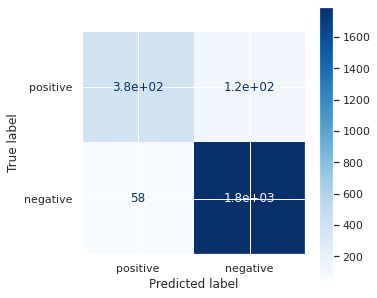


Classification Report

              precision    recall  f1-score   support

    positive       0.87      0.77      0.82       500
    negative       0.94      0.97      0.95      1850

    accuracy                           0.93      2350
   macro avg       0.90      0.87      0.88      2350
weighted avg       0.92      0.93      0.92      2350



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, axis = plt.subplots(1, 2, figsize=(14,5))
axis[0].plot(history_bd.history['val_loss'], label='val_loss')
axis[0].plot(history_bd.history['loss'], label='loss')
axis[0].legend()
axis[1].plot(history_bd.history['val_accuracy'], label='val_acc')
axis[1].plot(history_bd.history['accuracy'], label='acc')
axis[1].legend()
plt.show()


y_pred =  model_bd.predict(seqs_test).round().astype(int)[:,0]

acc_test = np.mean(sentiment_test == y_pred)

print("\nFINAL TEST ACCURACY: " , acc_test )

target_names = [str(i) for i in range(10)]

print("\nConfusion Matrix\n")
fig, ax = plt.subplots(figsize=(5, 5))
cm = confusion_matrix(sentiment_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sentiments_tags)
disp = disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

print("\nClassification Report\n")

print(classification_report(sentiment_test, y_pred, target_names=sentiments_tags))


The bidirectional model achieved approximately the same results as the recurrent model with the pre-trained embeddings, however, this one shows presence of overfitting. Therefore, the model with the best generalization ability is the one with pre-trained embeddings.  